In [2]:
library(xgboost)
library(dplyr)
library(rBayesianOptimization)

In [3]:
df_train_x <- read.csv("../data/df_train_x.csv") %>% select(-X) %>% data.matrix
df_test_x <- read.csv("../data/df_test_x.csv") %>% select(-X) %>% data.matrix
vec_train_y <- read.csv("../data/vec_train_y.csv") %>% select(-X) %>% data.matrix
vec_test_y <- read.csv("../data/vec_test_y.csv") %>% select(-X) %>% data.matrix


In [4]:
dtrain <- xgb.DMatrix(data = df_train_x, label = vec_train_y)
dtest <- xgb.DMatrix(data = df_test_x, label = vec_test_y)

In [5]:
base_model <- xgb.train(params = list(
                             objective = "binary:logistic",
                             eval_metric = "auc"),
                        data = dtrain, 
                        nround = 500,
                        watchlist=list(validation1=dtest),
                        early_stopping_rounds = 5)

[1]	validation1-auc:0.808163 
Will train until validation1_auc hasn't improved in 5 rounds.

[2]	validation1-auc:0.818779 
[3]	validation1-auc:0.819330 
[4]	validation1-auc:0.823855 
[5]	validation1-auc:0.826207 
[6]	validation1-auc:0.825159 
[7]	validation1-auc:0.828950 
[8]	validation1-auc:0.828250 
[9]	validation1-auc:0.828671 
[10]	validation1-auc:0.828895 
[11]	validation1-auc:0.830872 
[12]	validation1-auc:0.830298 
[13]	validation1-auc:0.830656 
[14]	validation1-auc:0.830441 
[15]	validation1-auc:0.829372 
[16]	validation1-auc:0.828130 
Stopping. Best iteration:
[11]	validation1-auc:0.830872



In [7]:
#install.packages("InformationValue")
library(InformationValue)
library(yardstick)


Loading required package: broom

Attaching package: 'yardstick'

The following objects are masked from 'package:InformationValue':

    npv, precision



In [8]:
vec_pred_y <- predict(base_model, dtest)
opt_cut <- optimalCutoff(vec_test_y, vec_pred_y)
vec_est_y <- ifelse(vec_pred_y <= opt_cut, 0, 1)


In [9]:
library(forcats)
options(yardstick.event_first = FALSE)
tbl_estimates <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(vec_est_y) %>% fct_recode(yes = "1", no = "0"),
    class_prob = vec_pred_y
)

head(tbl_estimates)

truth,estimate,class_prob
no,no,0.06031061
no,no,0.26500404
no,no,0.14983955
no,no,0.02391434
no,yes,0.77201778
no,no,0.02391434


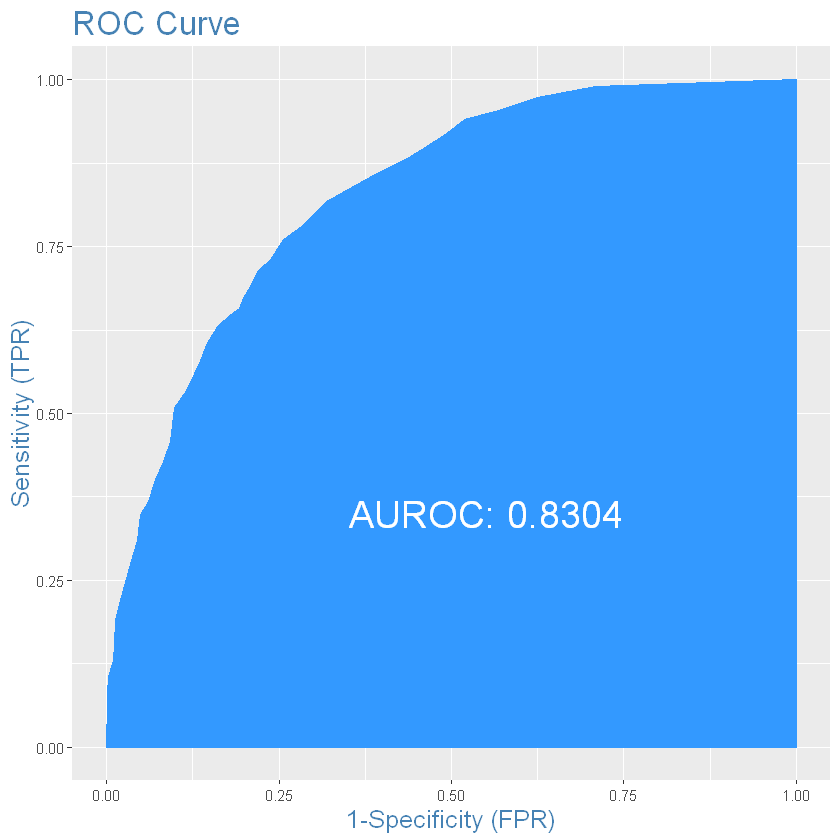

In [10]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

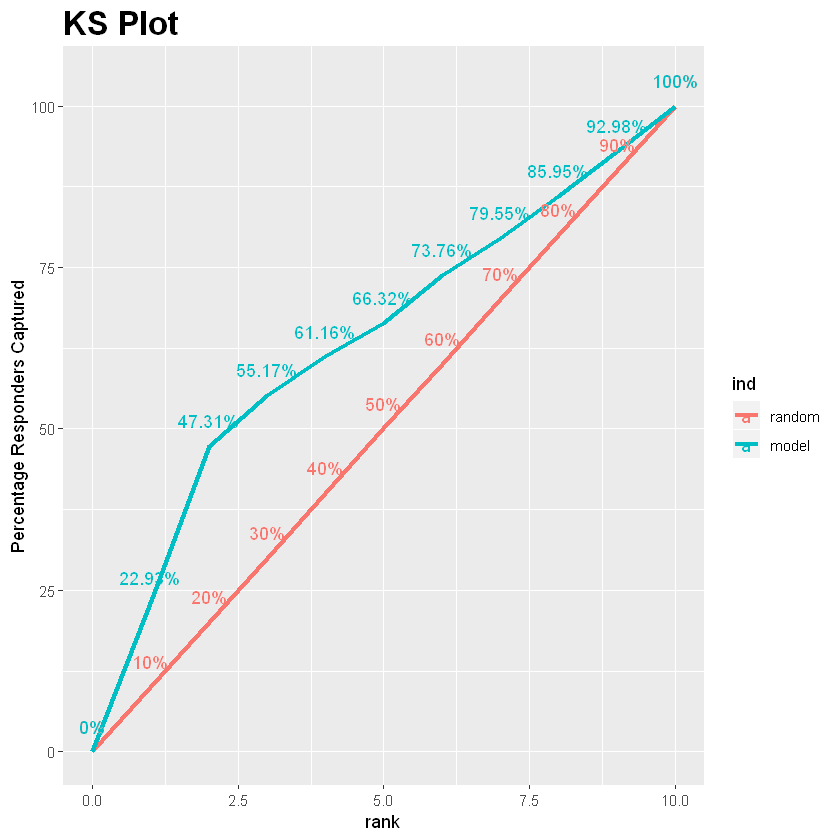

In [11]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y)

In [12]:
optimalCutoff(vec_test_y, vec_pred_y)

[1] 0.4975228

In [13]:
tbl_estimates %>% conf_mat(truth, estimate)

          Truth
Prediction   no  yes
       no  1147  238
       yes  127  246

In [23]:
# Accuracy
tbl_estimates %>% metrics(truth, estimate)

accuracy
0.78157


In [24]:
# Precision
tibble(
    precision = tbl_estimates %>% precision(truth, estimate),
    recall    = tbl_estimates %>% recall(truth, estimate)
)

precision,recall
0.6420455,0.4669421


### Tune model hyperparameters

In [27]:
cv_folds <- KFold(vec_train_y, nfolds = 5,
                  stratified = TRUE, seed = 456)

xgb_cv_bayes <- function(max.depth, min_child_weight, subsample, eta) {
  cv <- xgb.cv(params = list(booster = "gbtree", eta = eta,
                             max_depth = max.depth,
                             min_child_weight = min_child_weight,
                             subsample = subsample, colsample_bytree = 0.3,
                             lambda = 1, alpha = 0,
                             objective = "binary:logistic",
                             eval_metric = "auc"),
               data = dtrain, nround = 500,
               folds = cv_folds, prediction = TRUE, showsd = TRUE,
               early_stopping_rounds = 5, maximize = TRUE, verbose = 0)
  list(Score = max(cv$evaluation_log$test_auc_mean),
       Pred = cv$pred)
}
OPT_Res <- BayesianOptimization(xgb_cv_bayes,
                                bounds = list(max.depth = c(2L, 6L),
                                              min_child_weight = c(1L, 10L),
                                              subsample = c(0.5, 0.8),
                                              eta = c(0.1, 0.6)),  
                                init_grid_dt = NULL, init_points = 10, n_iter = 10,
                                acq = "ucb", kappa = 2.576, eps = 0.0,
                                verbose = TRUE)


ERROR: Error in vec_train_y$x: $ operator is invalid for atomic vectors


In [16]:
opt_model <- xgb.train(params = list(booster = "gbtree", eta = OPT_Res$Best_Par["eta"],
                             max_depth = OPT_Res$Best_Par["max.depth"],
                             min_child_weight = OPT_Res$Best_Par["min_child_weight"],
                             subsample = OPT_Res$Best_Par["subsample"], colsample_bytree = 0.3,
                             lambda = 1, alpha = 0,
                             objective = "binary:logistic",
                             eval_metric = "auc"),
               data = dtrain, nround = 500, watchlist=list(validation1=dtest),
               early_stopping_rounds = 5, maximize = TRUE, verbose = 0)

In [17]:
vec_pred_y <- predict(opt_model, dtest)
opt_cut <- optimalCutoff(vec_test_y, vec_pred_y)
vec_est_y <- ifelse(vec_pred_y <= opt_cut, 0, 1)


In [18]:
library(forcats)
options(yardstick.event_first = FALSE)
tbl_estimates <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(vec_est_y) %>% fct_recode(yes = "1", no = "0"),
    class_prob = vec_pred_y
)

head(tbl_estimates)

truth,estimate,class_prob
no,no,0.08156163
no,no,0.26513103
no,no,0.05185239
no,no,0.06271095
no,yes,0.55560333
no,no,0.05915695


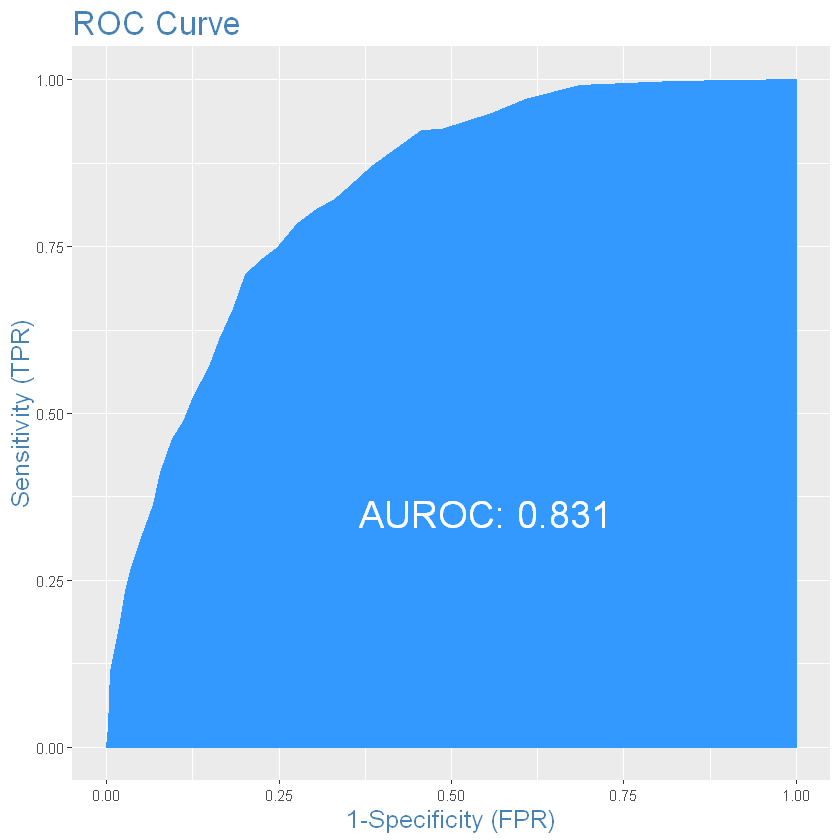

In [19]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

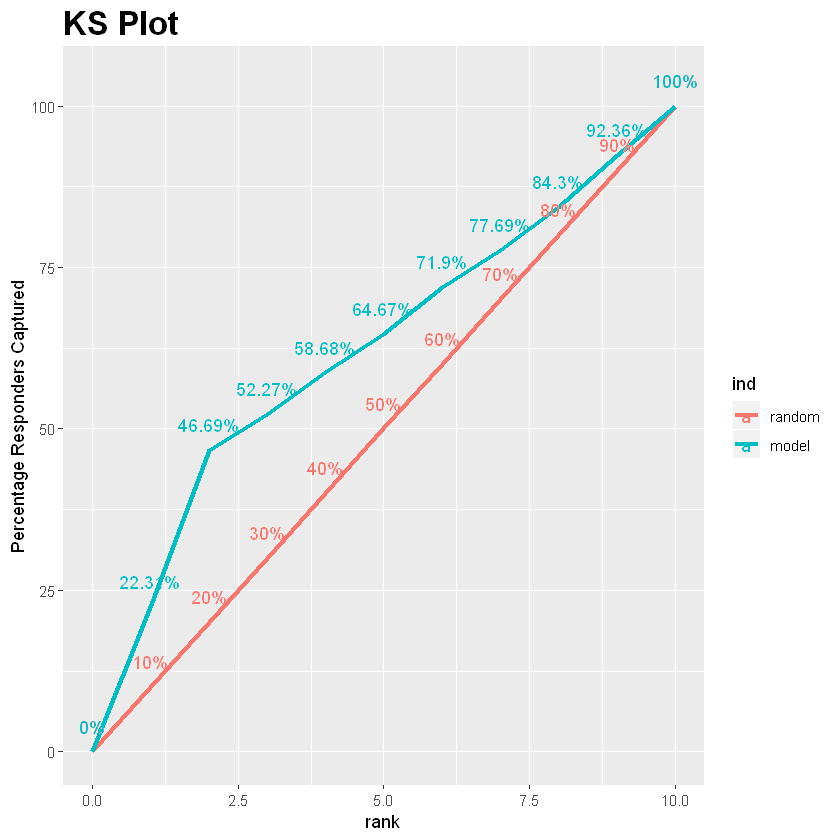

In [20]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y)

In [21]:
optimalCutoff(vec_test_y, vec_pred_y)

[1] 0.4550332

In [22]:
tbl_estimates %>% conf_mat(truth, estimate)

          Truth
Prediction   no  yes
       no  1148  258
       yes  126  226

In [25]:
# Accuracy
tbl_estimates %>% metrics(truth, estimate)

accuracy
0.78157


In [26]:
# Precision
tibble(
    precision = tbl_estimates %>% precision(truth, estimate),
    recall    = tbl_estimates %>% recall(truth, estimate)
)

precision,recall
0.6420455,0.4669421


In [ ]:
vec_pred_y <- predict(opt_model, dtest)

In [ ]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

In [ ]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_pred_y)

In [ ]:
optimalCutoff(vec_test_y, vec_pred_y)

In [33]:
library(corrr)
library(tidyquant)